<a href="https://colab.research.google.com/github/LeonHauch/bachelorarbeit/blob/main/BA_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Archiv.zip to Archiv.zip


In [ ]:
# unzip des Files 'Achiv.zip'
!unzip Archiv.zip


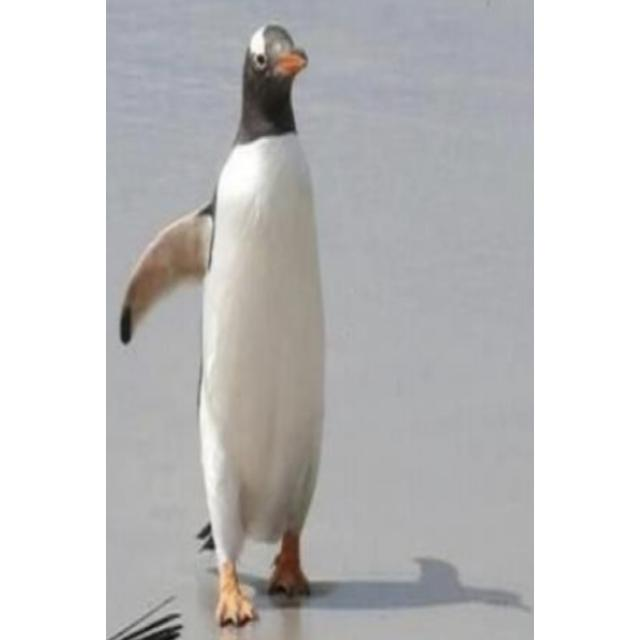

In [ ]:
from PIL import Image
from IPython.display import display
#öffnen eines Beispielbildes
img = Image.open('/content/train/train/image_id_000.jpg')
display(img)


In [ ]:
import os
import pandas as pd
import numpy as np
# Define the training image directory
train_image_dir = '/content/train/train/'

# Load all training images
train_image_files = [f for f in os.listdir(train_image_dir) if f.endswith('.jpg')]
train_images = [Image.open(os.path.join(train_image_dir, f)) for f in train_image_files]

# Load training annotations
train_annotations_path = '/content/train_annotations'
train_annotations = pd.read_json(train_annotations_path)

# Retrieve the labels for each training image
train_labels = train_annotations[train_annotations['image_id'].isin([int(f.split('_')[-1].split('.')[0]) for f in train_image_files])]['category_id'].values


In [ ]:
# Define the validation image directory
valid_image_dir = '/content/valid/valid/'

# Filter out the "._" files and load valid images
valid_image_files = [f for f in os.listdir(valid_image_dir) if f.endswith('.jpg') and not f.startswith('._')]
valid_images = [Image.open(os.path.join(valid_image_dir, f)) for f in valid_image_files]

# Load validation annotations
valid_annotations_path = '/content/valid_annotations'
valid_annotations = pd.read_json(valid_annotations_path)

# Retrieve the labels for each validation image
valid_labels = valid_annotations[valid_annotations['image_id'].isin([int(f.split('_')[-1].split('.')[0]) for f in valid_image_files])]['category_id'].values


In [ ]:
# Regularization, um weiter mit Modellen zu arbeiten. 110x110 hat sich als am performativsten erwiesen
IMG_SIZE = (110,110)  # Example size; can be adjusted based on your needs

train_images_resized = [img.resize(IMG_SIZE) for img in train_images]
valid_images_resized = [img.resize(IMG_SIZE) for img in valid_images]


In [ ]:
print("Number of training images:", len(train_images))
print("Number of training labels:", len(train_labels))

print("Number of validation images:", len(valid_images))
print("Number of validation labels:", len(valid_labels))


In [ ]:
# Convert lists of PIL Images to numpy arrays and normalize
X_train = np.array([np.array(img) for img in train_images_resized])
X_valid = np.array([np.array(img) for img in valid_images_resized])


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
# Fit des Dataaugmentation Generators
datagen.fit(X_train)


In [ ]:
#Initialisierung
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Definition des CNN Modells
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the total number of categories you have
NUM_CLASSES = len(np.unique(train_labels))

# Define a simple CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(110, 110, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Adjusting the labels
train_labels_adjusted = train_labels - 1
valid_labels_adjusted = valid_labels - 1


In [ ]:
# mit Data Augmentation
model.fit_generator(datagen.flow(X_train, train_labels_adjusted, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=10,
                    validation_data=(X_valid, valid_labels_adjusted))


In [ ]:
#ohne Data Augmentation
model.fit(X_train, train_labels_adjusted, epochs=10, validation_data=(X_valid, valid_labels_adjusted))
# Performance höher, als mit Data Augmentation

Epoch 1/10
16/16 [==============================] - 13s 49ms/step - loss: 37.1329 - accuracy: 0.5140 - val_loss: 0.9689 - val_accuracy: 0.3889
Epoch 2/10
16/16 [==============================] - 0s 13ms/step - loss: 0.7102 - accuracy: 0.5620 - val_loss: 0.7146 - val_accuracy: 0.5278
Epoch 3/10
16/16 [==============================] - 0s 13ms/step - loss: 0.6320 - accuracy: 0.6480 - val_loss: 0.6505 - val_accuracy: 0.5139
Epoch 4/10
16/16 [==============================] - 0s 13ms/step - loss: 0.5960 - accuracy: 0.6800 - val_loss: 1.3317 - val_accuracy: 0.4861
Epoch 5/10
16/16 [==============================] - 0s 13ms/step - loss: 0.5184 - accuracy: 0.7120 - val_loss: 0.8123 - val_accuracy: 0.4722
Epoch 6/10
16/16 [==============================] - 0s 13ms/step - loss: 0.4517 - accuracy: 0.7780 - val_loss: 0.9455 - val_accuracy: 0.4444
Epoch 7/10
16/16 [==============================] - 0s 13ms/step - loss: 0.4132 - accuracy: 0.8020 - val_loss: 1.3561 - val_accuracy: 0.6250
Epoch 8/10


In [ ]:
# Evaluate the model on the validation dataset
loss, accuracy = model.evaluate(X_valid, valid_labels_adjusted)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


3/3 [==============================] - 0s 6ms/step - loss: 2.2708 - accuracy: 0.5694
Validation Loss: 2.2708
Validation Accuracy: 0.5694


In [ ]:
#SVM
X_train_flat = [img.ravel() for img in X_train]
X_valid_flat = [img.ravel() for img in X_valid]


In [ ]:
# Scaling der Daten
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_valid_scaled = scaler.transform(X_valid_flat)


In [ ]:
# Fit von 3 Klassifikatoren
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the classifiers
classifiers = {
    'SVM': SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train_scaled, train_labels_adjusted)
    accuracy = clf.score(X_train_scaled, train_labels_adjusted)
    print(f"{name} Validation Accuracy: {accuracy:.4f}")


SVM Validation Accuracy: 0.8120
Random Forest Validation Accuracy: 0.9980
Decision Tree Validation Accuracy: 0.9980


  0%|          | 0/1000 [00:00<?, ?it/s]

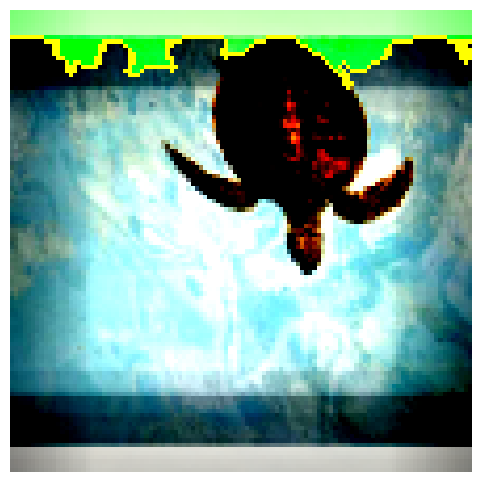

In [ ]:
# LIME mit Tree Modell
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Initialize LIME Image Explainer
explainer = lime_image.LimeImageExplainer()

# Choose a sample instance (e.g., the first instance in the validation set)
sample_instance = X_valid_scaled[1].reshape(110,110, 3)

# Get explanation
explanation = explainer.explain_instance(sample_instance,
                                         classifier_fn = lambda x: classifiers['Decision Tree'].predict_proba(scaler.transform(x.reshape(x.shape[0], -1))),
                                         top_labels=5, hide_color=0,
                                         num_samples=1000,
                                         segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2))

# Displaying the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

# Display the image with LIME explanation
plt.figure(figsize=(10, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


In [ ]:
!pip install shap lime

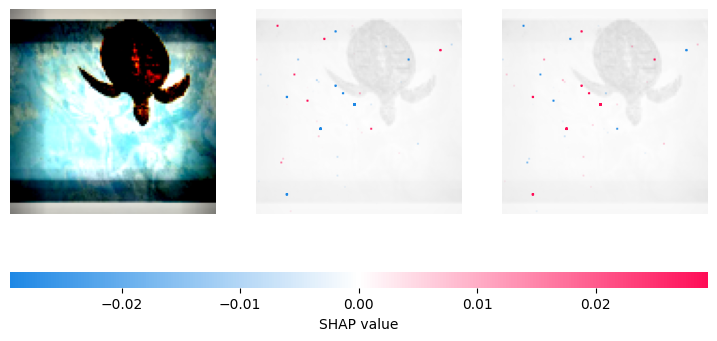

In [ ]:
# SHAP mit Tree Modell
import shap
# Define the SHAP explainer for the Random Forest model
shap_explainer = shap.TreeExplainer(classifiers['Decision Tree'])

# Calculate SHAP values for a flattened sample instance
shap_values = shap_explainer.shap_values(sample_instance.ravel())

# Reshape SHAP values to match the image dimensions
shap_values_reshaped = [s.reshape(110,110, 3) for s in shap_values]

# Plot SHAP values on the image
shap.image_plot(shap_values_reshaped, sample_instance.reshape(110,110, 3))


1/1 [==============================] - 0s 206ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


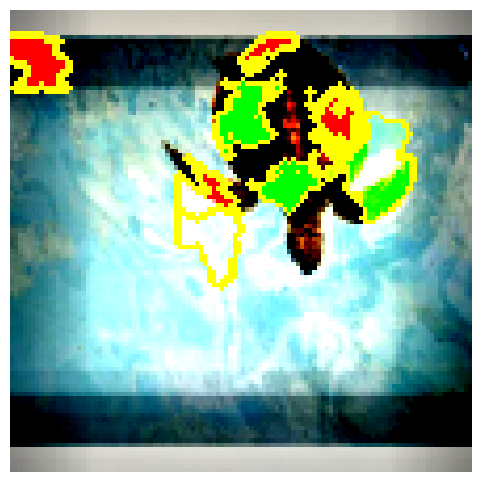

In [ ]:
# LIME mit CNN Modell
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

# Predict the class for the sample instance
predicted_probabilities = model.predict(np.array([sample_instance]))
predicted_label = np.argmax(predicted_probabilities[0])

# Initialize LIME Image Explainer
explainer_lime_cnn = lime_image.LimeImageExplainer()

# Get explanation using CNN
explanation_cnn = explainer_lime_cnn.explain_instance(sample_instance,
                                             classifier_fn = lambda x: model.predict(x),
                                             top_labels=5, hide_color=0,
                                             num_samples=1000,
                                             segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2))

# Displaying the explanation for the predicted class
temp, mask = explanation_cnn.get_image_and_mask(predicted_label, positive_only=False, num_features=10, hide_rest=False)
plt.figure(figsize=(10, 6))
plt.imshow(mark_boundaries(temp, mask))
plt.axis('off')
plt.show()


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


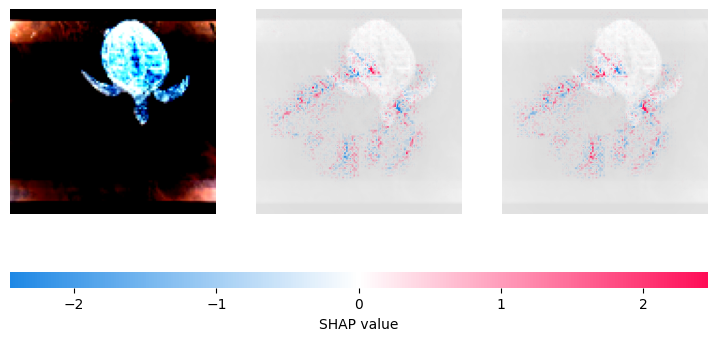

In [ ]:
# SHAP mit CNN Modell: Deep Explainer
import shap

# Create a Deep SHAP explainer
explainer_cnn = shap.DeepExplainer(model, X_train[:300])  # Using a subset of training data as the background dataset

# Calculate SHAP values for the sample instance
shap_values_cnn = explainer_cnn.shap_values(sample_instance.reshape(1, 110,110, 3))

# Plot SHAP values on the image
shap.image_plot(shap_values_cnn, -sample_instance.reshape(1, 110,110, 3))


In [ ]:
# SHAP mit CNN Modell: Kernel Explainer : nicht ausführbar
import shap

# Define the model prediction function
def f(x):
    return model.predict(x.reshape(-1, 110, 110, 3))

# Initialize KernelExplainer
background = X_train[:100].reshape(X_train[:100].shape[0], -1)  # Flatten the background dataset
explainer = shap.KernelExplainer(f, background)

# Flatten the sample instance
sample_instance_flattened = sample_instance.reshape(-1).reshape(1, -1)

# Calculate SHAP values for the flattened sample instance
shap_values_kernel = explainer.shap_values(sample_instance_flattened)

# Reshape SHAP values to the original image dimensions
shap_values_kernel_reshaped = [s.reshape(110, 110, 3) for s in shap_values_kernel]

# Plot SHAP values on the image
shap.image_plot(shap_values_kernel_reshaped, -sample_instance.reshape(110, 110, 3))


In [ ]:
import shap
import tensorflow as tf

print("SHAP version:", shap.__version__)
print("TensorFlow version:", tf.__version__)


SHAP version: 0.42.1
TensorFlow version: 2.12.0


In [ ]:
!pip install --upgrade shap
!pip install --upgrade tensorflow


In [ ]:
import shap
import tensorflow as tf

print("SHAP version:", shap.__version__)
print("TensorFlow version:", tf.__version__)


SHAP version: 0.42.1
TensorFlow version: 2.12.0


In [ ]:
# Vergleich der Ausführungszeit von 5 Instanzen
import time
import pandas as pd

# Select 5 random instances
random_indices = np.random.choice(X_valid_scaled.shape[0], 1, replace=False)
random_samples = [X_valid_scaled[i].reshape(110, 110, 3) for i in random_indices]

def lime_tree(instance):
    return explainer.explain_instance(instance,
                                      classifier_fn = lambda x: classifiers['Decision Tree'].predict_proba(scaler.transform(x.reshape(x.shape[0], -1))),
                                      top_labels=5, hide_color=0,
                                      num_samples=1000,
                                      segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2))

def shap_tree(instance):
    return shap_explainer.shap_values(instance.ravel())

def lime_cnn(instance):
    return explainer_lime_cnn.explain_instance(instance,
                                               classifier_fn = lambda x: model.predict(x),
                                               top_labels=5, hide_color=0,
                                               num_samples=1000,
                                               segmentation_fn=SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2))

def shap_cnn(instance):
    return explainer_cnn.shap_values(instance.reshape(1, 110, 110, 3))

# Measure execution times
methods = [lime_tree, shap_tree, lime_cnn, shap_cnn]
times = {method.__name__: 0 for method in methods}

for instance in random_samples:
    for method in methods:
        start_time = time.time()
        method(instance)
        elapsed_time = time.time() - start_time
        times[method.__name__] += elapsed_time

# Display results in a table
df = pd.DataFrame(times, index=["Ausführungszeit in Sekunden"]).transpose()
display(df)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


,Ausführungszeit in Sekunden
lime_tree,1.465850
shap_tree,0.000508
lime_cnn,7.761258
shap_cnn,1.504716
